# ASSIGNMENT 2: MovieLens Dataset.

The dataset describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. In this project we use standard (latest) version of the MovieLens dataset. As in the previous assignmnet we will analyzie and explore the data, then we will pre-process the data and build a rule based and clustering based recommender system. Our steps:

1. Analyzing and Exploring the data.
2. Pre-processing.
3. Rule based system.
4. Clustering.



### 01. Analyzing and Exploring the data - movie lens dataset.

##### 🧾 **step 1: information about number of movies and number of users**


In [2]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.sparse import csr_matrix
import recommendation as rec

In [3]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [44]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [45]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 1.0 GB


In [46]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [47]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [48]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [49]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [50]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

Number of ratings: 33832162
Number of unique movieId's: 83239
Number of unique users: 330975


##### 📽️ **step 2: distribution of movie ratings**

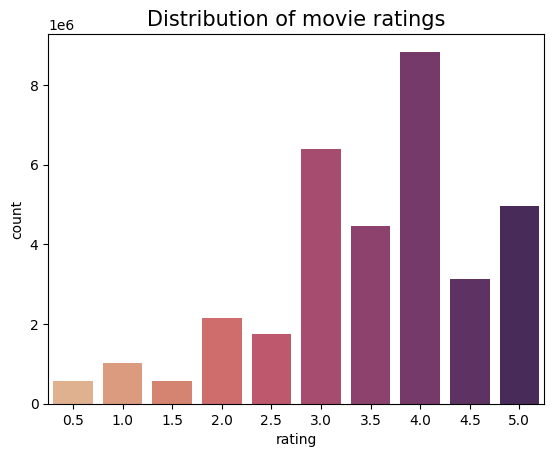

In [51]:
sns.countplot(x="rating", data = ratings, palette = "flare", hue="rating",legend=False)
plt.title("Distribution of movie ratings", fontsize = 15)
plt.show()

##### 📈 **step 3: most frequently rated movies**

In [52]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Shawshank Redemption, The (1994)                         122296
Forrest Gump (1994)                                      113581
Pulp Fiction (1994)                                      108756
Matrix, The (1999)                                       107056
Silence of the Lambs, The (1991)                         101802
Star Wars: Episode IV - A New Hope (1977)                 97202
Fight Club (1999)                                         86207
Schindler's List (1993)                                   84232
Jurassic Park (1993)                                      83026
Star Wars: Episode V - The Empire Strikes Back (1980)     80200
Name: count, dtype: int64

In [53]:
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")
genre_frequency

There are 35 genres.


Counter({'A': 19686,
         'd': 39606,
         'v': 5349,
         'e': 104474,
         'n': 67523,
         't': 45317,
         'u': 15691,
         'r': 124034,
         '|': 65751,
         'i': 60207,
         'm': 87816,
         'a': 102398,
         'o': 80981,
         'C': 34114,
         'h': 16042,
         'l': 36190,
         'y': 43878,
         'F': 9025,
         's': 24662,
         'R': 10172,
         'c': 34927,
         'D': 42964,
         'T': 11675,
         'H': 8570,
         'M': 5226,
         'S': 4850,
         '-': 5204,
         'I': 195,
         'X': 195,
         'W': 3991,
         'N': 354,
         '(': 7060,
         ' ': 14120,
         'g': 7060,
         ')': 7060})

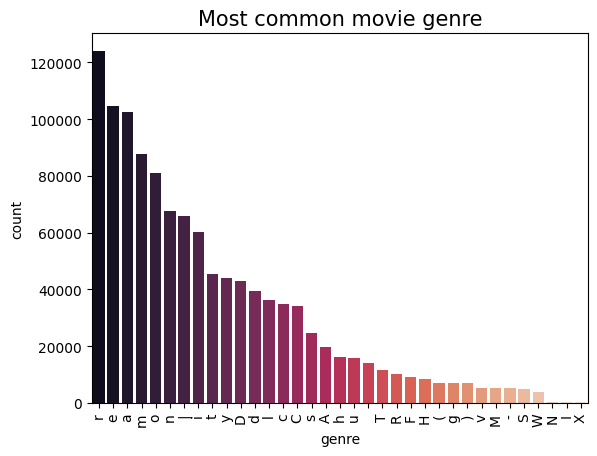

In [54]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', hue= "genre", data=genre_frequency_df.sort_values(by='count', ascending=False), palette="rocket")
plt.xticks(rotation=90)
plt.title("Most common movie genre", fontsize = 15)
plt.show()

##### 🧹 **step 4: cleaning dataset:** 
- _genres_ is expressed as a string with a pipe | separating each genre. We want to delete this pipe - we will create a list instead.
- _title_ we cannot extract year of the movie from the title, because some names of the movie repeat.

In [4]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


- _timestamp_ to delete, because it  won't help with recommendation system

In [5]:
del ratings['timestamp']

In [57]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


### 02. Data Pre-processing.

We want to use apriori algorithm and clustering methods to improve our recomendation system. Before that - there is a need to transform our data into an utility matrix. Utility matrix shows which user likes which movie.

##### 🍀 **step 1: shrinking the dataset**

📌 **note:** our datset is too big to hande - there are many methods to deal with that problem: 
- **data shrinking: by choosing the users who like maximum number of movies**
- batch processing: if your dataset is very large, you can try processing it in batches, which will reduce memory requirements; 
- sparse matrix: if your data is sparse (i.e., has a lot of zeros), you can continue working with the sparse matrix X without converting it into a dense matrix;
- apache spark: software which deals with big data

In [58]:
rec.create_chronological_mapping(ratings)

➕ top 10 visualization: {only visualization i do not use it}

In [39]:
top_10 = rec.shrinking_data(10, ratings)
top_10

,userId,movieId,rating
0,48766,1,3.5
1,48766,2,1.5
2,48766,3,3.0
3,48766,4,1.0
4,48766,5,2.5
...,...,...,...
107374,236260,92643,4.0
107375,236260,93116,3.0
107376,236260,93838,4.5
107377,236260,99114,3.0


In [37]:
top_10_final = top_10.groupby('userId')['movieId'].count()
top_10_final

userId
48766      9554
76618      8919
175998     9016
184775     7535
189614    33332
207216     9178
214831     7266
230765     7719
233891     7372
236260     7488
Name: movieId, dtype: int64

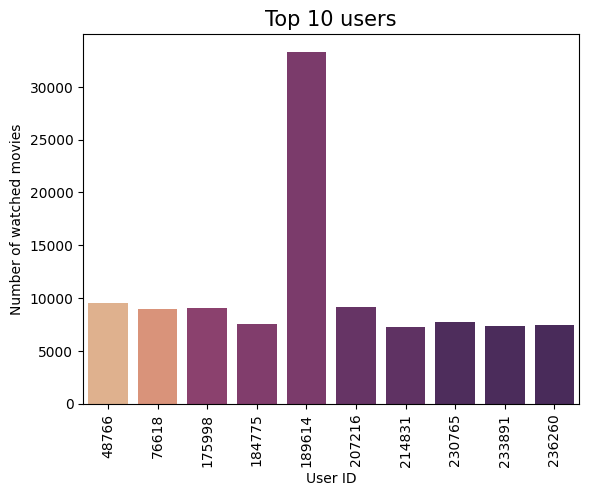

In [47]:
top_10_final_df = top_10_final.reset_index()
top_10_final_df.columns = ['userId', 'count']

sns.barplot(x='userId', y='count', hue='userId', 
            data=top_10_final_df.sort_values(by='count', ascending=False), 
            palette="flare", legend=False)

plt.xticks(rotation=90)
plt.title("Top 10 users", fontsize=15)
plt.xlabel('User ID')
plt.ylabel('Number of watched movies')
plt.show()

➕ important shrinking {now i use it}

In [6]:
shrinked_ratings = rec.shrinking_data(2000, ratings)

In [8]:
shrinked_ratings.shape

(4015502, 3)

In [22]:
shrinked_ratings[['userId', 'movieId']]

,userId,movieId
0,149,1
1,149,2
2,149,3
3,149,5
4,149,7
...,...,...
4015497,330914,267456
4015498,330914,269638
4015499,330914,270350
4015500,330914,275669


##### 🚀 **step 2: splitting the _raitings_ dataset**

In [10]:
train_df, test_df = rec.getTwoDatasets(shrinked_ratings)

In [11]:
train_df.shape

(2409301, 3)

In [12]:
test_df.shape

(1606201, 3)

In [25]:
train_df[train_df['userId'] == 149]

,userId,movieId,rating
0,149,1,4.0
1,149,2,2.5
2,149,3,0.5
3,149,5,2.5
4,149,7,2.0
...,...,...,...
1502,149,32596,2.5
1503,149,33004,4.0
1504,149,33162,3.0
1505,149,33493,4.0


📌 **note:** we can easily see that user 149 rated 1507 movies

##### 🗺️ **step 3: Utility matrix and mapping**

In [14]:
user2movie, movie2user = rec.create_mappings(train_df)

📌 **note:** create_mappings method creates two dictionaries. First one matches users with movies they rated. Second one matches movies with users which rated given movie

- utility matrix: train dataset

In [18]:
utility_matrix_train = rec.create_utility_matrix(train_df)

In [19]:
utility_matrix_train

movieId,1,2,3,4,5,6,7,8,9,10,...,288901,288903,288917,288923,288935,288953,288957,288959,288965,288975
userId,,,,,,,,,,,,,,,,,,,,,
149,4.0,2.5,0.5,0.0,2.5,0.0,2.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305,5.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
461,4.5,4.5,0.0,0.0,0.0,4.0,0.0,0.0,4.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,4.5,2.0,0.0,0.0,0.0,1.5,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,4.0,3.0,0.0,0.0,2.5,3.0,0.0,0.0,2.5,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198235,4.0,3.0,0.0,4.0,2.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198283,4.0,3.0,1.0,0.0,1.5,5.0,0.0,0.0,2.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198291,4.0,3.5,3.5,0.0,0.0,3.5,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- utility matrix: test dataset

In [20]:
utility_matrix_test = rec.create_utility_matrix(test_df)

In [21]:
utility_matrix_test

movieId,1,2,3,4,5,6,7,8,9,10,...,288865,288869,288897,288913,288927,288945,288947,288949,288951,288983
userId,,,,,,,,,,,,,,,,,,,,,
198413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198767,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198797,4.0,2.0,0.0,0.0,0.0,3.5,3.5,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199142,4.5,0.0,2.5,0.0,2.5,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199388,3.0,0.0,1.5,0.0,1.0,4.0,0.0,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330507,4.0,2.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330517,2.0,0.0,0.0,0.0,3.0,3.5,2.5,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330535,3.0,3.0,0.0,0.0,0.0,3.5,0.0,0.0,3.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
